In [11]:
# %% Imports
import os, time, json, urllib.request, shutil
from pathlib import Path
from typing import List, Dict

import torch
import pandas as pd
import matplotlib.pyplot as plt

from ultralytics import YOLO  # YOLOv* and YOLO‑World
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [12]:
# ─── Cell 1: Setup paths ─────────────────────────────────────────────────────────
yolov11_weight   = "weights/bestyolo.pt"
yoloworld_weight = "weights/yolov8l-worldv2.pt"   # ← download and point here
owlv2_weight     = "weights/owlv2.pt"       # ← download and point here

image_folder      = "dataset/images"
yolo_annot_folder = "dataset/labels"


In [13]:
# ─── Cell 2: Data preprocess ────────────────────────────────────────────────────
import os
import pandas as pd
from PIL import Image

# gather all image paths
image_paths = sorted([
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])

# build corresponding YOLO-label paths
label_paths = [
    os.path.join(yolo_annot_folder, os.path.splitext(os.path.basename(p))[0] + ".txt")
    for p in image_paths
]

# YOLO DataFrame
yolo_df = pd.DataFrame({
    "image_path": image_paths,
    "label_path": label_paths
})

# Build a COCO‐style DataFrame from YOLO-format labels
coco_rows = []
for img_path, lbl_path in zip(image_paths, label_paths):
    img = Image.open(img_path)
    w, h = img.size
    with open(lbl_path, "r") as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())
            # convert normalized center→pixel xywh
            x1 = (xc - bw/2) * w
            y1 = (yc - bh/2) * h
            coco_rows.append({
                "image_path": img_path,
                "category_id": int(cls),
                "bbox": [x1, y1, bw * w, bh * h]
            })

coco_df = pd.DataFrame(coco_rows)


In [14]:
# ─── Cell X: GPU memory used in GB ─────────────────────────────────────────────
import subprocess

def get_gpu_mem_gb():
    """
    Returns the currently used GPU memory (first GPU) in gigabytes.
    """
    # query only “memory.used” (in MiB)
    out = subprocess.check_output([
        "nvidia-smi",
        "--query-gpu=memory.used",
        "--format=csv,noheader,nounits"
    ])
    used_mib = float(out.decode().strip().split()[0])
    used_gb  = used_mib / 1024.0
    return used_gb

In [15]:
# ─── Cell 3: Create data.yaml with absolute path ───────────────────────────────
import yaml

# ← hard-code your project root here:
project_root = r"C:\Users\chrap\Documents\code\vision_pipeline\model_evaluation"

# number of classes (as a pure Python int)
num_classes = int(coco_df.category_id.max()) + 1

data_cfg = {
    'path':  project_root,           # absolute root
    'train': 'dataset/images',       # relative to path/
    'val':   'dataset/images',       # same for validation
    'nc':    num_classes,            # number of classes
    #'names': [str(i) for i in range(num_classes)]
    'names': ["graffiti"]
}

with open('data.yaml', 'w') as f:
    yaml.safe_dump(data_cfg, f, sort_keys=False)

# Optional: verify contents
print(yaml.safe_load(open("data.yaml")))

{'path': 'C:\\Users\\chrap\\Documents\\code\\vision_pipeline\\model_evaluation', 'train': 'dataset/images', 'val': 'dataset/images', 'nc': 1, 'names': ['graffiti']}


In [16]:
# ─── Cell DEBUG: sanity-check your dataframes ─────────────────────────────────
import os

print("Number of images:", len(yolo_df))
print("Number of unique images in coco_df (with at least one GT box):",
      coco_df.image_path.nunique())

# Check for any images where the label file doesn’t exist or is empty
missing_lbl = [p for p, l in zip(yolo_df.image_path, yolo_df.label_path)
               if not os.path.isfile(l)]
empty_lbl   = [l for l in yolo_df.label_path if os.path.isfile(l) and os.path.getsize(l)==0]
print("Images missing a .txt label file:", missing_lbl)
print("Label files present but empty:", empty_lbl)

# Show a few entries
print("\nyolo_df head:\n", yolo_df.head())
print("\ncoco_df head:\n", coco_df.head())


Number of images: 15
Number of unique images in coco_df (with at least one GT box): 15
Images missing a .txt label file: []
Label files present but empty: []

yolo_df head:
                     image_path                   label_path
0  dataset/images\IMG_9050.JPG  dataset/labels\IMG_9050.txt
1  dataset/images\IMG_9051.JPG  dataset/labels\IMG_9051.txt
2  dataset/images\IMG_9052.JPG  dataset/labels\IMG_9052.txt
3  dataset/images\IMG_9053.JPG  dataset/labels\IMG_9053.txt
4  dataset/images\IMG_9054.JPG  dataset/labels\IMG_9054.txt

coco_df head:
                     image_path  category_id  \
0  dataset/images\IMG_9050.JPG            0   
1  dataset/images\IMG_9050.JPG            0   
2  dataset/images\IMG_9051.JPG            0   
3  dataset/images\IMG_9051.JPG            0   
4  dataset/images\IMG_9051.JPG            0   

                                                bbox  
0  [4.562268803945777, 17.755856966707753, 313.81...  
1  [65.59802712700369, 0.12330456226879782, 186.0...  
2 

In [17]:
# ─── Cell 4: YOLOv11 inference ─────────────────────────────────────────────────
import time
import subprocess
from ultralytics import YOLO

def infer_yolov11(df, weights, data_yaml='data.yaml'):
    model = YOLO(weights)
    _ = model(df.image_path.iloc[:1].tolist())  # warm up

    start = time.time()
    results = model.val(data=data_yaml, verbose=False)
    end = time.time()

    gpu_util   = get_gpu_mem_gb()
    map50      = results.box.ap50        # was map50
    map50_95   = results.box.ap          # was map50_95
    avg_ms     = (end - start) * 1000 / len(df)

    return gpu_util, map50, map50_95, avg_ms


In [ ]:
# ─── Cell C: YOLO-World open‑vocab mAP full-sweep eval ────────────────────────
import os
import time
import subprocess
from ultralytics import YOLO
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torch
import cv2  # for saving plotted images

def infer_yoloworld_eval(df,
                         weights,
                         class_names=["urban tag graffiti"],
                         viz_conf=0.3,
                         save_vis=True,
                         vis_dir="yolo_world_vis"):
    """
    Performs YOLO-World inference, computes full-sweep mAP, and optionally saves visualizations.
    viz_conf: threshold only for drawing images (NOT for mAP calculation).
    """
    model = YOLO(weights)
    model.set_classes(class_names)
    _ = model(df.image_path.iloc[:1].tolist())  # warm up

    # 1) inference (conf=0.0 to keep all detections)
    start = time.time()
    results = model.predict(
        source=df.image_path.tolist(),
        conf=0.0,
        verbose=False
    )
    end = time.time()

    # 2) visualize above threshold
    if save_vis:
        os.makedirs(vis_dir, exist_ok=True)
        for img_path, res in zip(df.image_path.tolist(), results):
            # use model.predict(conf=viz_conf) just for drawing if needed
            im_arr = res.plot(conf=viz_conf)
            out_path = os.path.join(vis_dir, os.path.basename(img_path))
            cv2.imwrite(out_path, im_arr)

    # 3) build preds & targets
    preds, targets = [], []
    for img_path, res in zip(df.image_path.tolist(), results):
        boxes  = torch.tensor(res.boxes.xyxy.cpu())
        scores = torch.tensor(res.boxes.conf.cpu())
        labels = torch.zeros(len(scores), dtype=torch.int64)  # single-class: 0
        preds.append({"boxes": boxes, "scores": scores, "labels": labels})

        gt = coco_df[coco_df.image_path == img_path]
        if not gt.empty:
            xywh = torch.tensor(gt.bbox.tolist())
            x1y1 = xywh[:, :2]
            wh   = xywh[:, 2:]
            x2y2 = x1y1 + wh
            gt_boxes  = torch.cat([x1y1, x2y2], dim=1)
            gt_labels = torch.zeros(len(gt_boxes), dtype=torch.int64)
        else:
            gt_boxes  = torch.zeros((0,4), dtype=torch.float32)
            gt_labels = torch.zeros((0,), dtype=torch.int64)
        targets.append({"boxes": gt_boxes, "labels": gt_labels})

    # 4) compute mAP
    metric = MeanAveragePrecision(iou_type="bbox")
    metric.update(preds, targets)
    mAPs = metric.compute()
    map50    = mAPs["map_50"].item()
    map50_95 = mAPs["map"].item()

    # 5) GPU memory used (MiB → GB)
    out = subprocess.check_output([
        "nvidia-smi",
        "--query-gpu=memory.used",
        "--format=csv,noheader,nounits"
    ])
    used_mib   = float(out.decode().strip())
    gpu_mem_gb = used_mib / 1024.0

    # 6) avg inference time
    avg_ms = (end - start) * 1000 / len(df)

    return gpu_mem_gb, map50, map50_95, avg_ms


In [19]:
# ─── Cell X: OWLv2 inference & full‐sweep mAP for “graffiti” on GPU ─────────────
import os
import time
import subprocess
import torch
from transformers import Owlv2Processor, Owlv2ForObjectDetection
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from PIL import Image
import cv2
import numpy as np

def infer_owlv2_sweep(df,
                      model_id="google/owlv2-base-patch16-ensemble",
                      text_label="graffiti",
                      viz_conf=0.05,
                      save_vis=False,
                      vis_dir="owlv2_sweep_vis"):
    """
    Full‐sweep mAP for OWLv2 (fair comparison to YOLO’s .val()):
    - threshold=0.0 keeps all detections for PR curve.
    - MeanAveragePrecision integrates over all scores.
    Returns: (gpu_mem_gb, map50, map50_95, avg_ms)
    Optionally draws boxes ≥viz_conf when save_vis=True.
    """
    # pick device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load processor & model
    processor = Owlv2Processor.from_pretrained(model_id)
    model     = Owlv2ForObjectDetection.from_pretrained(model_id).to(device)
    model.eval()

    # warm‑up
    img0 = Image.open(df.image_path.iloc[0]).convert("RGB")
    warm = processor(text=[[text_label]], images=img0, return_tensors="pt")
    warm = {k: v.to(device) for k, v in warm.items()}
    with torch.no_grad():
        _ = model(**warm)

    preds, targets = [], []
    start = time.time()

    for img_path in df.image_path.tolist():
        img    = Image.open(img_path).convert("RGB")
        inputs = processor(text=[[text_label]], images=img, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)

        # full sweep: threshold=0.0
        proc = processor.post_process_grounded_object_detection(
            outputs=outputs,
            threshold=0.0,
            target_sizes=torch.tensor([(img.height, img.width)]).cpu(),
            text_labels=[text_label]
        )[0]

        # optional viz: only boxes with score ≥ viz_conf
        if save_vis:
            os.makedirs(vis_dir, exist_ok=True)
            vis_img = np.array(img)[:, :, ::-1].copy()  # RGB→BGR
            for box, score in zip(proc["boxes"], proc["scores"]):
                if float(score) >= viz_conf:
                    x1, y1, x2, y2 = map(int, box.tolist())
                    cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.imwrite(os.path.join(vis_dir, os.path.basename(img_path)), vis_img)

        # build preds (all scores)
        boxes  = proc["boxes"].cpu()
        scores = proc["scores"].cpu()
        labels = torch.zeros(len(scores), dtype=torch.int64)
        preds.append({"boxes": boxes, "scores": scores, "labels": labels})

        # build targets
        gt = coco_df[coco_df.image_path == img_path]
        if not gt.empty:
            xywh = torch.tensor(gt.bbox.tolist())
            x1y1 = xywh[:, :2]
            wh   = xywh[:, 2:]
            x2y2 = x1y1 + wh
            gt_boxes  = torch.cat([x1y1, x2y2], dim=1)
            gt_labels = torch.zeros(len(gt_boxes), dtype=torch.int64)
        else:
            gt_boxes  = torch.zeros((0,4), dtype=torch.float32)
            gt_labels = torch.zeros((0,),   dtype=torch.int64)
        targets.append({"boxes": gt_boxes, "labels": gt_labels})

    end = time.time()

    # compute mAP over full confidence sweep
    metric = MeanAveragePrecision(iou_type="bbox")
    metric.update(preds, targets)
    mAPs     = metric.compute()
    map50    = mAPs["map_50"].item()
    map50_95 = mAPs["map"].item()

    # GPU memory used (GiB)
    out       = subprocess.check_output([
        "nvidia-smi", "--query-gpu=memory.used", "--format=csv,noheader,nounits"
    ]).decode().strip()
    gpu_mem_gb = float(out) / 1024.0

    # average inference time (ms/image)
    avg_ms = (end - start) * 1000 / len(df)

    return gpu_mem_gb, map50, map50_95, avg_ms

# Example usage:
# gpu_gb, m50, m5095, avg_ms = infer_owlv2_sweep(
#     yolo_df,
#     text_label="graffiti",
#     viz_conf=0.1,
#     save_vis=True,
#     vis_dir="owlv2_sweep_vis"
# )



In [20]:
# ─── Cell 6: Run all three and collect ─────────────────────────────────────────
metrics = {}
metrics["owlv2"]    = infer_owlv2_sweep(yolo_df)
metrics["yolov11"]  = infer_yolov11(yolo_df,  yolov11_weight)
metrics["yolo-world"] = infer_yoloworld_eval(yolo_df, yoloworld_weight)

# unpack into lists for plotting
models     = list(metrics.keys())
gpu_utils  = [metrics[m][0] for m in models]
maps50     = [metrics[m][1] for m in models]
maps50_95  = [metrics[m][2] for m in models]
speeds_ms  = [metrics[m][3] for m in models]


c:\Users\chrap\miniconda3\envs\colab\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)



0: 480x640 2 graffitis, 61.8ms
Speed: 2.2ms preprocess, 61.8ms inference, 19.0ms postprocess per image at shape (1, 3, 480, 640)
Ultralytics 8.3.127  Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 2094.41642.9 MB/s, size: 2944.5 KB)


val: Scanning C:\Users\chrap\Documents\code\vision_pipeline\model_evaluation\dataset\labels.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


                   all         15         31      0.951      0.677      0.772      0.711
Speed: 0.4ms preprocess, 23.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\val7

0: 480x640 (no detections), 32.6ms
Speed: 1.4ms preprocess, 32.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


C:\Users\chrap\AppData\Local\Temp\ipykernel_34508\410530449.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(res.boxes.xyxy.cpu())
C:\Users\chrap\AppData\Local\Temp\ipykernel_34508\410530449.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(res.boxes.conf.cpu())


C:\Users\chrap\AppData\Local\Temp\ipykernel_34508\4118450438.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  maps50_clean    = [float(x) if x is not None else 0.0 for x in maps50]
C:\Users\chrap\AppData\Local\Temp\ipykernel_34508\4118450438.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  maps50_95_clean = [float(x) if x is not None else 0.0 for x in maps50_95]


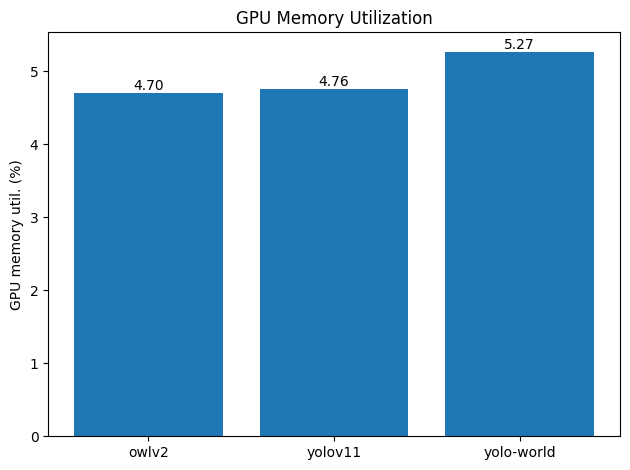

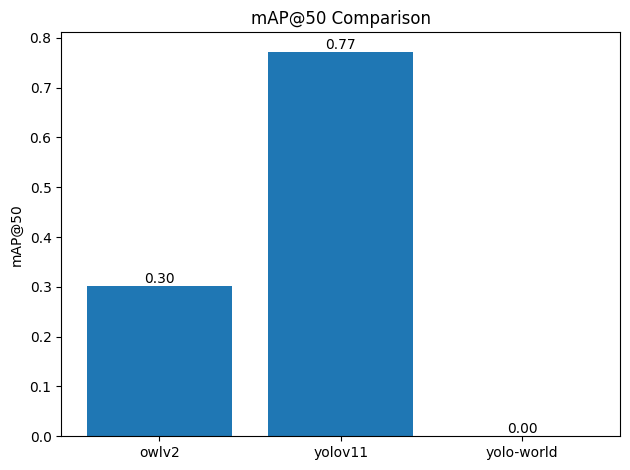

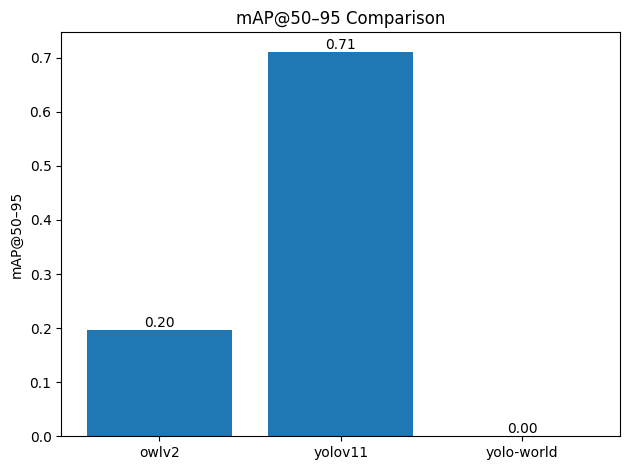

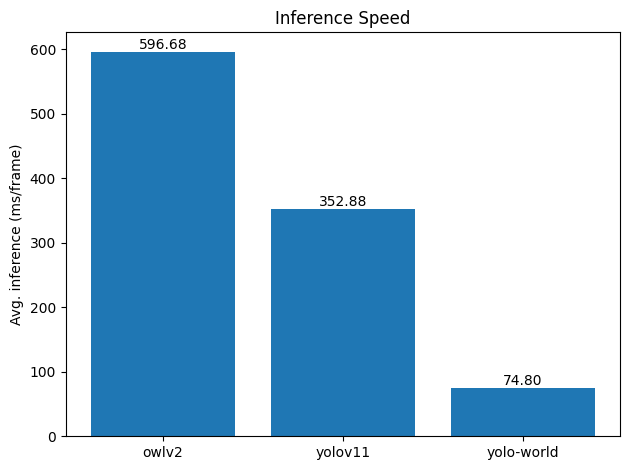

In [21]:
# ─── Cell 7: Plot bar charts (with inline display) ────────────────────────────
%matplotlib inline
import matplotlib.pyplot as plt

# sanitize metrics: replace None with 0.0, cast to float
gpu_utils_clean = [float(x) if x is not None else 0.0 for x in gpu_utils]
maps50_clean    = [float(x) if x is not None else 0.0 for x in maps50]
maps50_95_clean = [float(x) if x is not None else 0.0 for x in maps50_95]
speeds_ms_clean = [float(x) if x is not None else 0.0 for x in speeds_ms]

def plot_bar(vals, ylabel, title):
    plt.figure()
    bars = plt.bar(models, vals)
    plt.ylabel(ylabel)
    plt.title(title)
    for bar, v in zip(bars, vals):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f"{v:.2f}", ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

plot_bar(gpu_utils_clean, "GPU memory util. (%)", "GPU Memory Utilization")
plot_bar(maps50_clean,    "mAP@50",             "mAP@50 Comparison")
plot_bar(maps50_95_clean, "mAP@50–95",          "mAP@50–95 Comparison")
plot_bar(speeds_ms_clean, "Avg. inference (ms/frame)", "Inference Speed")
